<a href="https://colab.research.google.com/github/ajhamdi/Pytorch_toturials_3D/blob/master/Neaural_renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\color{green}{\text{Neural Mesh Renderer in pytorch}}$
## [Kato etal (CVPR18')](http://openaccess.thecvf.com/content_cvpr_2018/papers/Kato_Neural_3D_Mesh_CVPR_2018_paper.pdf)
### implements four examples to use Mesh Neaural Renderer with pytorch
-------------------------------------
--------------------------

#### importing relevent modules 

In [0]:
!pip install -q torch==1.0.0 torchvision
!pip install git+https://github.com/daniilidis-group/neural_renderer
!git clone https://github.com/daniilidis-group/neural_renderer
!pip install pillow==4.1.1
# !nvidia-smi

  Cloning https://github.com/daniilidis-group/neural_renderer to /tmp/pip-req-build-n3ea_3iy
  Running setup.py bdist_wheel for neural-renderer ... - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f56imaf7/wheels/e9/3c/9c/9ba2a503ab2ac4826aac560d3fa7bd55b1efad648fa4d10973
Successfully built neural-renderer
fatal: destination path 'neural_renderer' already exists and is not an empty directory.
    100% |████████████████████████████████| 5.7MB 7.4MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
from __future__ import division
import os
import argparse
import glob

import torch
import torch.nn as nn
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import imageio
from IPython.display import display, HTML, Image

import neural_renderer as nr

data_dir = 'neural_renderer/examples/data'

#### supporting functions

In [0]:
def make_gif(filename):
    with imageio.get_writer(filename, mode='I') as writer:
        for filename in sorted(glob.glob('/tmp/_tmp_*.png')):
            writer.append_data(imread(filename))
            os.remove(filename)
    writer.close()

## example1 : rendering obj file from different angles

In [0]:
filename_obj =  os.path.join(data_dir,'teapot.obj')
camera_distance = 2.732
filename_ref = os.path.join(data_dir,'example1_ref.png')
file_out = os.path.join(data_dir,'example1_out.gif')
file_opt = os.path.join(data_dir,'example1_opt.gif')

# other settings

elevation = 35
texture_size = 2

# load .obj
vertices, faces = nr.load_obj(filename_obj)
vertices = vertices[None, :, :]  # [num_vertices, XYZ] -> [batch_size=1, num_vertices, XYZ]
faces = faces[None, :, :]  # [num_faces, 3] -> [batch_size=1, num_faces, 3]

# create texture [batch_size=1, num_faces, texture_size, texture_size, texture_size, RGB]
textures = torch.ones(1, faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32).cuda()


# to gpu

# create renderer
renderer = nr.Renderer(camera_mode='look_at')
image_collection = []
# draw object
loop = tqdm(range(0, 360, 4))
writer = imageio.get_writer(file_out, mode='I')
for num, azimuth in enumerate(loop):
    loop.set_description('Drawing')
    renderer.eye = nr.get_points_from_angles(camera_distance, elevation, azimuth)
    images = renderer(vertices, faces, textures,)  # [batch_size, RGB, image_size, image_size]
    image = images.detach().cpu().numpy()[0].transpose((1, 2, 0))  # [image_size, image_size, RGB]
    writer.append_data((255*image).astype(np.uint8))
    image_collection.append((255*image).astype(np.uint8))
writer.close()



  0%|          | 0/90 [00:00<?, ?it/s]

Drawing:   0%|          | 0/90 [00:00<?, ?it/s]

Drawing:   1%|          | 1/90 [00:00<00:12,  7.23it/s]

Drawing:   1%|          | 1/90 [00:00<00:12,  7.23it/s]

Drawing:   2%|▏         | 2/90 [00:00<00:11,  7.64it/s]

Drawing:   2%|▏         | 2/90 [00:00<00:11,  7.64it/s]

Drawing:   3%|▎         | 3/90 [00:00<00:10,  8.01it/s]

Drawing:   3%|▎         | 3/90 [00:00<00:10,  8.01it/s]

Drawing:   4%|▍         | 4/90 [00:00<00:10,  8.40it/s]

Drawing:   4%|▍         | 4/90 [00:00<00:10,  8.40it/s]

Drawing:   4%|▍         | 4/90 [00:00<00:10,  8.40it/s]

Drawing:   7%|▋         | 6/90 [00:00<00:09,  8.91it/s]

Drawing:   7%|▋         | 6/90 [00:00<00:09,  8.91it/s]

Drawing:   7%|▋         | 6/90 [00:00<00:09,  8.91it/s]

Drawing:   9%|▉         | 8/90 [00:00<00:08,  9.46it/s]

Drawing:   9%|▉         | 8/90 [00:00<00:08,  9.46it/s]

Drawing:   9%|▉         | 8/90 [00:00<00:08,  9.46it/s]

Drawing:  11%|█         | 10/90 [00:01<00:08,  9.99it/

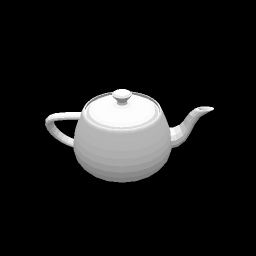

In [0]:
!cd neural_renderer/examples/data/ && cp example1_out.gif example1_out.gif.png
Image(filename=file_out+".png")

## example2 : optimizaing the mesh vertices

In [0]:
filename_ref = os.path.join(data_dir,'example2_ref.png')
file_out = os.path.join(data_dir,'example2_out.gif')
file_opt = os.path.join(data_dir,'example2_opt.gif')

class Model(nn.Module):
    def __init__(self, filename_obj, filename_ref):
        super(Model, self).__init__()

        # load .obj
        vertices, faces = nr.load_obj(filename_obj)
        self.vertices = nn.Parameter(vertices[None, :, :])
        self.register_buffer('faces', faces[None, :, :])

        # create textures
        texture_size = 2
        textures = torch.ones(1, self.faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32)
        self.register_buffer('textures', textures)

        # load reference image
        image_ref = torch.from_numpy(imread(filename_ref).astype(np.float32).mean(-1) / 255.)[None, ::]
        self.register_buffer('image_ref', image_ref)

        # setup renderer
        renderer = nr.Renderer(camera_mode='look_at')
        self.renderer = renderer

    def forward(self):
        self.renderer.eye = nr.get_points_from_angles(2.732, 0, 90)
        image = self.renderer(self.vertices, self.faces, mode='silhouettes')
        loss = torch.sum((image - self.image_ref[None, :, :])**2)
        return loss

In [0]:
model = Model(filename_obj, filename_ref)
model.cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
# optimizer.setup(model)
loop = tqdm(range(300))
for i in loop:
    loop.set_description('Optimizing')
    # optimizer.target.cleargrads()
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    images = model.renderer(model.vertices, model.faces, mode='silhouettes')
    image = images.detach().cpu().numpy()[0]
    imsave('/tmp/_tmp_%04d.png' % i, image)
make_gif(file_opt)

# draw object
loop = tqdm(range(0, 360, 4))
for num, azimuth in enumerate(loop):
    loop.set_description('Drawing')
    model.renderer.eye = nr.get_points_from_angles(2.732, 0, azimuth)
    images = model.renderer(model.vertices, model.faces, model.textures)
    image = images.detach().cpu().numpy()[0].transpose((1, 2, 0))
    imsave('/tmp/_tmp_%04d.png' % num, image)
make_gif(file_out)



  0%|          | 0/300 [00:00<?, ?it/s]

Optimizing:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


Optimizing:   0%|          | 1/300 [00:00<01:19,  3.77it/s]

Optimizing:   0%|          | 1/300 [00:00<01:19,  3.77it/s]

Optimizing:   1%|          | 2/300 [00:00<01:16,  3.91it/s]

Optimizing:   1%|          | 2/300 [00:00<01:16,  3.91it/s]

Optimizing:   1%|          | 3/300 [00:00<01:12,  4.12it/s]

Optimizing:   1%|          | 3/300 [00:00<01:12,  4.12it/s]

Optimizing:   1%|▏         | 4/300 [00:00<01:07,  4.36it/s]

Optimizing:   1%|▏         | 4/300 [00:00<01:07,  4.36it/s]

Optimizing:   2%|▏         | 5/300 [00:01<01:03,  4.67it/s]

Optimizing:   2%|▏         | 5/300 [00:01<01:03,  4.67it/s]

Optimizing:   2%|▏         | 6/300 [00:01<01:00,  4.83it/s]

Optimizing:   2%|▏         | 6/300 [00:01<01:00,  4.8

optimization: ...


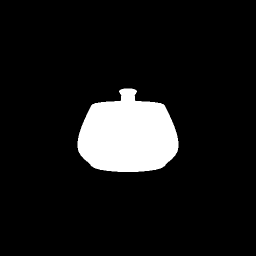

In [0]:
!cd neural_renderer/examples/data/ && cp example2_opt.gif example2_opt.gif.png
print("optimization: ..."); Image(filename=file_opt+".png")


outpput mesh: ...


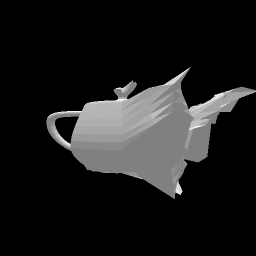

In [0]:
!cd neural_renderer/examples/data/ && cp example2_out.gif example2_out.gif.png
print("outpput mesh: ..."); Image(filename=file_out+".png")

## example3 : optimizaing mesh texture

In [0]:
filename_ref = os.path.join(data_dir,'example3_ref.png')
file_out = os.path.join(data_dir,'example3_out.gif')
file_opt = os.path.join(data_dir,'example3_opt.gif')

class Model(nn.Module):
    def __init__(self, filename_obj, filename_ref):
        super(Model, self).__init__()
        vertices, faces = nr.load_obj(filename_obj)
        self.register_buffer('vertices', vertices[None, :, :])
        self.register_buffer('faces', faces[None, :, :])

        # create textures
        texture_size = 4
        textures = torch.zeros(1, self.faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32)
        self.textures = nn.Parameter(textures)

        # load reference image
        image_ref = torch.from_numpy(imread(filename_ref).astype('float32') / 255.).permute(2,0,1)[None, ::]
        self.register_buffer('image_ref', image_ref)

        # setup renderer
        renderer = nr.Renderer(camera_mode='look_at')
        renderer.perspective = False
        renderer.light_intensity_directional = 0.0
        renderer.light_intensity_ambient = 1.0
        self.renderer = renderer


    def forward(self):
        self.renderer.eye = nr.get_points_from_angles(2.732, 0, np.random.uniform(0, 360))
        image = self.renderer(self.vertices, self.faces, torch.tanh(self.textures))
        loss = torch.sum((image - self.image_ref) ** 2)
        return loss

In [0]:

model = Model(filename_obj, filename_ref)
model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.5,0.999))
loop = tqdm(range(300))
for _ in loop:
    loop.set_description('Optimizing')
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

# draw object
loop = tqdm(range(0, 360, 4))
for num, azimuth in enumerate(loop):
    loop.set_description('Drawing')
    model.renderer.eye = nr.get_points_from_angles(2.732, 0, azimuth)
    images = model.renderer(model.vertices, model.faces, torch.tanh(model.textures))
    image = images.detach().cpu().numpy()[0].transpose((1, 2, 0))
    imsave('/tmp/_tmp_%04d.png' % num, image)
make_gif(file_out)




  0%|          | 0/300 [00:00<?, ?it/s]

Optimizing:   0%|          | 0/300 [00:00<?, ?it/s]

Optimizing:   0%|          | 1/300 [00:00<00:30,  9.78it/s]

Optimizing:   0%|          | 1/300 [00:00<00:30,  9.78it/s]

Optimizing:   1%|          | 2/300 [00:00<00:43,  6.80it/s]

Optimizing:   1%|          | 2/300 [00:00<00:43,  6.80it/s]

Optimizing:   1%|          | 3/300 [00:00<00:55,  5.34it/s]

Optimizing:   1%|          | 3/300 [00:00<00:55,  5.34it/s]

Optimizing:   1%|▏         | 4/300 [00:00<01:00,  4.93it/s]

Optimizing:   1%|▏         | 4/300 [00:00<01:00,  4.93it/s]

Optimizing:   2%|▏         | 5/300 [00:01<01:01,  4.78it/s]

Optimizing:   2%|▏         | 5/300 [00:01<01:01,  4.78it/s]

Optimizing:   2%|▏         | 6/300 [00:01<01:03,  4.65it/s]

Optimizing:   2%|▏         | 6/300 [00:01<01:03,  4.65it/s]

Optimizing:   2%|▏         | 7/300 [00:01<01:03,  4.65it/s]

Optimizing:   2%|▏         | 7/300 [00:01<01:03,  4.65it/s]

Optimizing:   3%|▎         | 8/300 [00:01<01:03,  

output colorful mesh: ...


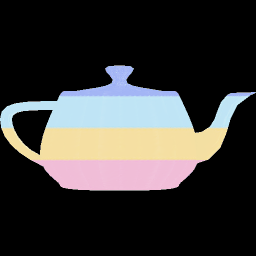

In [0]:
!cd neural_renderer/examples/data/ && cp example3_out.gif example3_out.gif.png
print("output colorful mesh: ..."); Image(filename=file_out+".png")

## example4 : optimizaing Camera external paramters 

In [0]:
filename_ref = os.path.join(data_dir,'example4_ref.png')
file_out = os.path.join(data_dir,'example4_out.gif')
file_opt = os.path.join(data_dir,'example4_opt.gif')
is_make_reference_image = False

class Model(nn.Module):
    def __init__(self, filename_obj, filename_ref=None):
        super(Model, self).__init__()
        # load .obj
        vertices, faces = nr.load_obj(filename_obj)
        self.register_buffer('vertices', vertices[None, :, :])
        self.register_buffer('faces', faces[None, :, :])

        # create textures
        texture_size = 2
        textures = torch.ones(1, self.faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32)
        self.register_buffer('textures', textures)

        # load reference image
        image_ref = torch.from_numpy((imread(filename_ref).max(-1) != 0).astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        # camera parameters
        self.camera_position = nn.Parameter(torch.from_numpy(np.array([6, 10, -14], dtype=np.float32)))

        # setup renderer
        renderer = nr.Renderer(camera_mode='look_at')
        renderer.eye = self.camera_position
        self.renderer = renderer

    def forward(self):
        image = self.renderer(self.vertices, self.faces, mode='silhouettes')
        loss = torch.sum((image - self.image_ref[None, :, :]) ** 2)
        return loss





def make_reference_image(filename_ref, filename_obj):
    model = Model(filename_obj)
    model.cuda()

    model.renderer.eye = nr.get_points_from_angles(2.732, 30, -15)
    images = model.renderer.render(model.vertices, model.faces, torch.tanh(model.textures))
    image = images.detach().cpu().numpy()[0]
    imsave(filename_ref, image)

In [0]:
if is_make_reference_image:
    make_reference_image(filename_ref, filename_obj)

model = Model(filename_obj, filename_ref)
model.cuda()

# optimizer = chainer.optimizers.Adam(alpha=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loop = tqdm(range(1000))
for i in loop:
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    images = model.renderer(model.vertices, model.faces, torch.tanh(model.textures))
    image = images.detach().cpu().numpy()[0].transpose(1,2,0)
    imsave('/tmp/_tmp_%04d.png' % i, image)
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    if loss.item() < 70:
        break
make_gif(file_out)




  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /tmp/_tmp_0000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Optimizing (loss 8444.8750):   0%|          | 0/1000 [00:00<?, ?it/s]

Optimizing (loss 8444.8750):   0%|          | 1/1000 [00:00<04:42,  3.54it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /tmp/_tmp_0001.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Optimizing (loss 8438.6250):   0%|          | 1/1000 [00:00<04:42,  3.54it/s]

Optimizing (loss 8438.6250):   0%|          | 2/1000 [00:00<04:25,  3.76it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /tmp/_tmp_0002.png is a low contrast image
  warn('%s is a low contras

finding the camera pose: ...


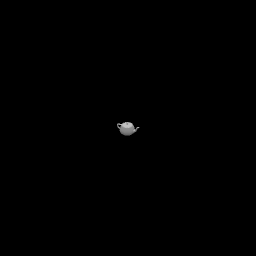

In [0]:
!cd neural_renderer/examples/data/ && cp example4_out.gif example4_out.gif.png
print("finding the camera pose: ..."); Image(filename=file_out+".png")